In [88]:
#Loading necessary packages and defining global variables
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from collections import defaultdict
import os
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd
from sys import platform

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")
OUTPUT_DIR_TRAIN='data/train.dat'
OUTPUT_DIR_TEST='data/test1.dat'

NUM_RESTS = 5138
NUM_USERS = 3579

In [89]:
def get_sparse_mat(filename):
  
    '''
    
    Inputs: 
        -filename: a string containing the name of the file from which we want
                    to extract the data. In our case it can be either train.dat
                    or test.dat
                    
    Returns a python list of size 3579 (number of users) with each element of
    the list being a list of tuples (restaurantID, rating).
    
    '''
    
    sparse_mat = []
    

    data = pd.read_csv(filename)
    for i in range(0, 3579):
        sparse_mat.append([])
    
    n = data.shape[0]
    #print(data.iloc[0])
    #print(data)
    for i in range(0, n):
        sparse_mat[int(data.iloc[i][0])].append(tuple([int(data.iloc[i][1]),float(data.iloc[i][2])]))
    
    
    return sparse_mat

In [90]:
train_smat = get_sparse_mat(OUTPUT_DIR_TRAIN)
test_smat = get_sparse_mat(OUTPUT_DIR_TEST)

In [104]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X_sam = torch.zeros(5138)
        y_sam = torch.zeros(5138)
        for i in range(len(self.X[index])):
            X_sam[self.X[index][i][0]] = self.X[index][i][1]

        for i in range(len(self.y[index])):
            y_sam[self.y[index][i][0]] = self.y[index][i][1]

        return X_sam, y_sam

In [105]:
train_dataset = Dataset(train_smat,train_smat)
test_dataset = Dataset(train_smat, test_smat)

In [106]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6 if platform == 'linux' else 0}
training_generator = data.DataLoader(train_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))
validation_generator = data.DataLoader(test_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))

In [107]:
class DAE(nn.Module):
    def __init__(self):
       
        super(DAE,self).__init__()
        
        self.fc1 = nn.Linear(5138,512)
        self.fc2 = nn.Linear(512, 8)
        self.fc3 = nn.Linear(8,512)
        self.fc4 = nn.Linear(512, 5138)
        self.act1 = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)
        self.bn1 = nn.BatchNorm1d(num_features=5138)
        self.bn2 = nn.BatchNorm1d(num_features=16)
        self.bn3 = nn.BatchNorm1d(num_features=256)
        
        
    def forward(self, x):
             
        out = torch.zeros(x.shape[0], 5138)
        
        
        #x = self.bn1(x)
        #x = (self.dropout(torch.nn.functional.tanh(self.fc1(x))))
        #x = (self.dropout(torch.nn.functional.tanh(self.fc2(x))))
        #x = (self.dropout(torch.nn.functional.tanh(self.fc3(x))))
        #x = self.fc4(x)
        x = ((torch.nn.functional.tanh(self.fc1(x))))
        x = ((torch.nn.functional.tanh(self.fc2(x))))
        x = ((torch.nn.functional.tanh(self.fc3(x))))
        x = self.fc4(x)
        out = x
     
        return out

In [108]:
def masked_loss(preds, labels):
    
    loss = 0

    preds = torch.Tensor(preds)
    labels = torch.Tensor(labels)
    tempMask = torch.where(labels > 0, torch.ones(labels.shape[0], labels.shape[1]),torch.zeros(labels.shape[0], labels.shape[1]) )
    reqPred = tempMask * preds
    noOfElem = torch.sum(tempMask)
    error = torch.sum(torch.abs(reqPred - labels))
    loss = error / noOfElem
    
    return loss


In [109]:
def masked_loss2(preds, labels):
        
    loss = 0

    
    preds = torch.Tensor(preds)
    labels = torch.Tensor(labels)
    tempMask = torch.where(labels > 0, torch.ones(labels.shape[0], labels.shape[1]),torch.zeros(labels.shape[0], labels.shape[1]) )
    reqPred = tempMask * preds
    noOfElem = torch.sum(tempMask)
    error = torch.sum((reqPred - labels)**2)
    loss = error / noOfElem
   
    return loss


In [110]:
def train(net, criterion, opti, training_generator, validation_generator, max_epochs = 10):
    

    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        running_loss = 0 #Accumulate the loss in each iteration of the epoch in this variable
        cnt = 0 #Increment it each time to find the number iterations in the epoch.
        # Training iterations
        for batch_X, batch_y in training_generator:
            opti.zero_grad() #Clears the gradients of all variables.
            cnt = cnt + 1
            output = net(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            opti.step()
            running_loss += loss.item()
           

        print("Epoch {}: Training Loss {}".format(epoch+1, running_loss/cnt))
        train_losses.append(running_loss/cnt)
        
        running_loss = 0
        cnt = 0
        net = net.eval()
        with torch.set_grad_enabled(False):
            for batch_X, batch_y in validation_generator:
                cnt = cnt + 1
                output = net(batch_X)
                loss = criterion(output, batch_y)
                running_loss += loss.item()
                
        print("Epoch {}: Validation Loss {}".format(epoch+1, running_loss/cnt))
        
        val_losses.append(running_loss/cnt)
        net = net.train()
    return train_losses, val_losses

In [98]:
#NEW TRAIN
net = DAE()
opti = torch.optim.SGD(net.parameters(), lr = 0.03, momentum=0.64)
train_losses, val_losses = train(net, masked_loss2, opti, training_generator, validation_generator, 70)

Epoch 1: Training Loss 12.529168665409088
Epoch 1: Validation Loss 7.521562848772321
Epoch 2: Training Loss 5.163106807640621
Epoch 2: Validation Loss 3.518974666084562
Epoch 3: Training Loss 2.7648908623627255
Epoch 3: Validation Loss 2.2667444476059506
Epoch 4: Training Loss 1.8846383967569895
Epoch 4: Validation Loss 1.7159340807369776
Epoch 5: Training Loss 1.4787166906254632
Epoch 5: Validation Loss 1.4243858797209603
Epoch 6: Training Loss 1.2537599738155092
Epoch 6: Validation Loss 1.248938038945198
Epoch 7: Training Loss 1.1142250576189585
Epoch 7: Validation Loss 1.133238279393741
Epoch 8: Training Loss 1.0078308401363236
Epoch 8: Validation Loss 1.0534089314086097
Epoch 9: Training Loss 0.9459085645420211
Epoch 9: Validation Loss 0.9950328703437533
Epoch 10: Training Loss 0.9120245405605861
Epoch 10: Validation Loss 0.951267631990569
Epoch 11: Training Loss 0.8688166237303189
Epoch 11: Validation Loss 0.9190270070518766
Epoch 12: Training Loss 0.8448324246065957
Epoch 12: Val

Text(0.5, 0, 'Epochs')

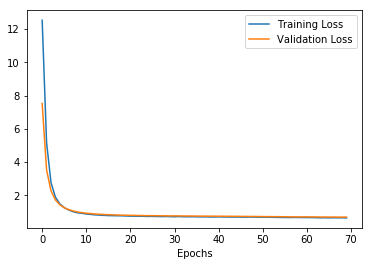

In [99]:
# Finally we plot the graphs for loss vs epochs.
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')

In [75]:
def get_predictions(net, train_data = train_smat):
    
    def get_test_smat(filename = 'data/test_hidden.dat'):
        sparse_dict = defaultdict(list)
        for line in open(filename):
            splitted_line = line.split(',')
            sparse_dict[int(splitted_line[0])].append((int(splitted_line[1])))

        sparse_mat = []
        sKeys = sorted(sparse_dict)
        for key in sKeys:
            sparse_mat.append(sparse_dict[key])
        
        return sparse_mat
            
            
    test_smat = get_test_smat()
    preds = []
    for i in range(len(train_data)):
        
        #Getting the actual vector from the sparse representation
        x = torch.zeros(5138)
        for j in range(len(train_data[i])):
            x[train_data[i][j][0]] = train_data[i][j][1]
        with torch.set_grad_enabled(False):
            pred =  net(x.unsqueeze(0)).detach().numpy().squeeze() 
        
        pred = pred[test_smat[i]]
        user_rest_pred = np.concatenate([i*np.ones((len(pred),1),dtype=np.int),np.array(test_smat[i],dtype=np.int)[:,None], np.array(pred)[:,None]],axis = 1)
        preds += user_rest_pred.tolist()
        
    preds = np.array(preds)
    df = pd.DataFrame(preds)
    df[0] = df[0].astype('int')
    df[1] = df[1].astype('int')
    df[2] = df[2].astype('float16')
    df = df.drop(df.columns[[0, 1]], axis=1)
    df.to_csv('predictions.csv', index = True, header = False)
    
    return df

In [76]:
net = net.eval()
df = get_predictions(net)
df.head()

,2
0,4.390625
1,3.962891
2,3.878906
3,4.597656
4,4.195312
